# Better Sampling

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", True)

import chex
import numpy as np
from functools import partial

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Demo Data

In [3]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 5_000
n_features = 2
noise = 0.05

X, y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)

data = X[:]

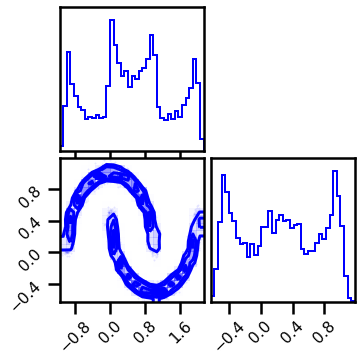

In [4]:
# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [5]:
X = jnp.array(data, dtype=np.float64)

## Model

In [6]:
from rbig_jax.transforms.block import RBIGBlockInit
from rbig_jax.models.iterative import init_default_rbig_block
from rbig_jax.transforms.logit import InitLogitTransform, InitSigmoidTransform
from rbig_jax.transforms.kde import InitUniKDETransform
from rbig_jax.transforms.rotation import InitPCARotation
from rbig_jax.transforms.inversecdf import (
    GaussCDF,
    InverseGaussCDF,
    InitGaussCDF,
    InitInverseGaussCDF,
)

In [7]:
# parameters
data_shape = X.shape
jitted = True
support_extension = 20
init_kde_fs = InitUniKDETransform(
    shape=data_shape, jitted=jitted, support_extension=support_extension
)

# Gaussian version
init_igauss_cdf = InitInverseGaussCDF(jitted=jitted)

# init rotation
init_pca_fs = InitPCARotation(jitted=jitted)

In [8]:
method = "histogram"
# initializae block
# rbig_block_init_fs = init_default_rbig_block(shape=data_shape, method=method)

rbig_block_init_fs = [init_kde_fs, init_igauss_cdf, init_pca_fs]

# create an RBIG "block" init
rbig_block_init = RBIGBlockInit(init_functions=rbig_block_init_fs)

In [9]:
# forward and params
X_g, bijectors = rbig_block_init.forward_and_bijector(X)

# alternatively just the forward
X_g = rbig_block_init.forward(X)

Text(0.5, 0.98, 'Forward Transformation')

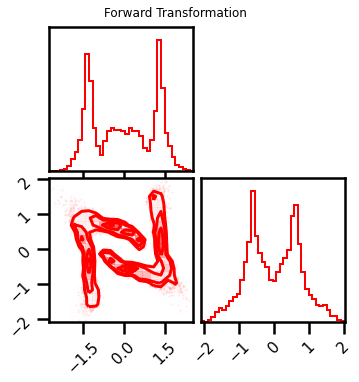

In [10]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")

## Training

In [11]:
from rbig_jax.training.iterative import train_info_loss_model

# define training params
verbose = True
n_layers_remove = 50
interval = 10
max_layers = 100

# run iterative training
X_g, rbig_model_info = train_info_loss_model(
    X=X,
    rbig_block_init=rbig_block_init,
    verbose=verbose,
    interval=interval,
    n_layers_remove=n_layers_remove,
    max_layers=max_layers,
)

Layer 10 - Cum. Info Reduction: 2.157 - Elapsed Time: 4.1767 secs
Layer 20 - Cum. Info Reduction: 2.654 - Elapsed Time: 6.9646 secs
Layer 30 - Cum. Info Reduction: 2.821 - Elapsed Time: 9.9360 secs
Layer 40 - Cum. Info Reduction: 2.821 - Elapsed Time: 12.8265 secs
Layer 50 - Cum. Info Reduction: 2.821 - Elapsed Time: 15.7340 secs
Layer 60 - Cum. Info Reduction: 2.821 - Elapsed Time: 18.5755 secs
Layer 70 - Cum. Info Reduction: 2.821 - Elapsed Time: 21.5152 secs
Layer 80 - Cum. Info Reduction: 2.821 - Elapsed Time: 24.2947 secs
Layer 90 - Cum. Info Reduction: 3.016 - Elapsed Time: 27.0505 secs
Layer 100 - Cum. Info Reduction: 3.374 - Elapsed Time: 29.7772 secs
Converged at Layer: 100
Final Number of layers: 50 (Blocks: 16)
Total Time: 29.7833 secs


#### Information Reduction Evolution

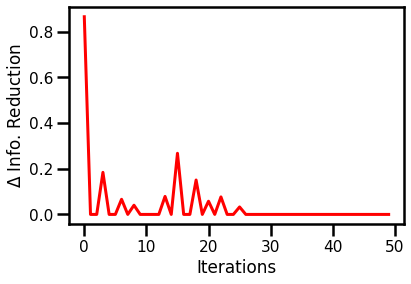

In [12]:
fig, ax = plt.subplots()
ax.plot(rbig_model_info.info_loss, color="red")
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction")
plt.show()

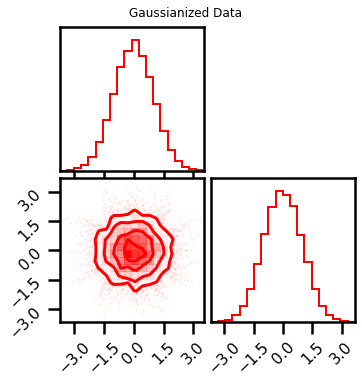

In [19]:
fig = corner.corner(X_g, color="red")
fig.suptitle("Gaussianized Data")
plt.show()

#### Negative Log-Likelihood

In [13]:
nll = rbig_model_info.score(X)
print(f"NLL Score: {nll:.4f}")

NLL Score: 0.4056


## Sampling

In [14]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model_info.sample(seed=seed, n_samples=n_samples)

CPU times: user 12.4 s, sys: 1.81 s, total: 14.2 s
Wall time: 4.73 s


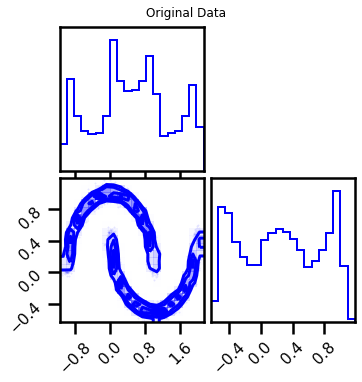

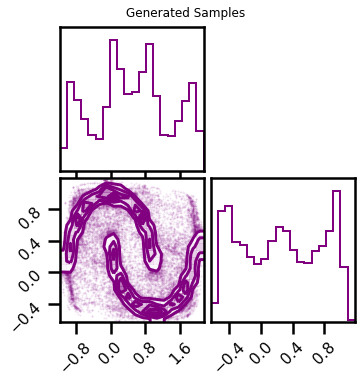

In [15]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Better Sampling

In [16]:
from rbig_jax.models.sampling import GFSampling
from rbig_jax.transforms.block import RBIGBlockInit
from rbig_jax.transforms.histogram import InitUniHistTransform

In [17]:
# parameters
data_shape = X.shape
jitted = True
support_extension = 20
init_kde_fs = InitUniKDETransform(
    shape=data_shape, jitted=jitted, support_extension=support_extension
)
init_hist_fs = InitUniHistTransform(
    n_samples=X.shape[0], jitted=jitted, support_extension=support_extension
)
# Gaussian version
init_igauss_cdf = InitInverseGaussCDF(jitted=jitted)


rbig_sampler_transform = RBIGBlockInit(init_functions=[init_kde_fs, init_igauss_cdf])

rbig_model_sampler = GFSampling(
    bijectors=rbig_model_info.bijectors,
    base_dist=rbig_model_info.base_dist,
    marginal_init_f=rbig_sampler_transform,
)

In [18]:
%%time

# number of samples
n_samples = 100_000
batch_size = 10_000
seed = 42
jitted = False

X_samples = rbig_model_sampler.sample(seed=seed, n_samples=n_samples, jitted=jitted, batch_size=batch_size)

100%|██████████| 10/10 [03:05<00:00, 18.57s/it]

CPU times: user 30min 46s, sys: 32.2 s, total: 31min 19s
Wall time: 3min 5s


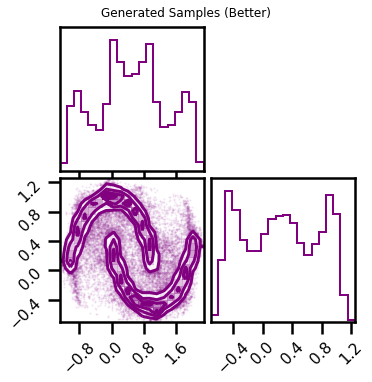

In [20]:
fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples (Better)")
plt.show()